Normalising flow with coupling architecture replaced with slope constrained architecture!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from torch.utils import tensorboard

# from architectures.base_model_2 import BaseModel
# from layers.lipschitzlinear import LipschitzLinear
# from projections.fc_projections import identity, bjorck_orthonormalize_fc, layerwise_orthogonal_fc
from utils import metrics, utilities, spline_utils
# from layers.lipschitzlinear import LipschitzLinear
# from dataloader.Function_1D import Function1D, generate_testing_set, slope_1_ae, slope_1_flat, cosines, threshold
# from activations.linearspline import LinearSpline
# from architectures.simple_fc import SimpleFC

from architectures.simple_fc_slope_constrained import SimpleFCSlopeConstrained

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons

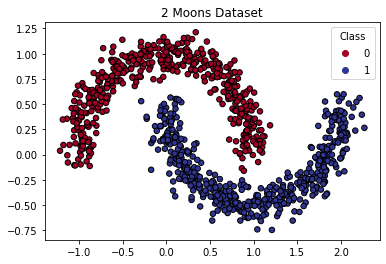

In [2]:
# Generate the 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create scatter plot with color-coding based on labels
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k', s=30)

# Add title and labels
plt.title("2 Moons Dataset")

# Add legend with labels for each class
plt.legend(*scatter.legend_elements(), title="Class")


In [3]:
def compute_jacobian(x, z):
    """
    Computes the Jacobian matrix of the model f at x.

    Args:
    - x (torch.Tensor): Input tensor (single data point, shape: [1, input_dim]).
    - z (torch.Tensor): Transformed tensor (output from the model, shape: [1, output_dim]).

    Returns:
    - torch.Tensor: The Jacobian matrix (shape: [output_dim, input_dim]).
    """
    # Ensure x and z are batch size 1
    assert x.size(0) == 1, "Input x must have batch size of 1."
    assert z.size(0) == 1, "Transformed_z must have batch size of 1."

    # Compute the Jacobian row by row
    jacobian_rows = []
    output_dim = z.size(1)
    for i in range(output_dim):
        unit_vector = torch.zeros_like(z)
        unit_vector[0, i] = 1  # Create a unit vector for the i-th output
        # Compute the vector-Jacobian product (VJP)
        vjp = torch.autograd.grad(outputs=z,
                                inputs=x,
                                grad_outputs=unit_vector,
                                retain_graph=True,
                                create_graph=True)[0]
        jacobian_rows.append(vjp)

    # Stack rows to form the Jacobian matrix
    jacobian = torch.stack(jacobian_rows, dim=0).squeeze()

    return jacobian



In [4]:
def loss_NF(input_x, z):
    """
    Calculate the Negative Log-Likelihood (NLL) loss.

    Args:
    - input_x (torch.Tensor): Original input data x.
    - z (torch.Tensor): Transformed data (z = f(x)).
    
    Returns:
    - torch.Tensor: The calculated loss value.
    """
    # Calculate the first term of the loss
    first_term = 0.5 * torch.sum(z**2)

    # Calculate the second term: log |det(J_f(x_i))| for each x_i
    second_term = 0
    for i in range(z.size(0)):  # Loop over each example
        x_i = input_x[i].unsqueeze(0)  # Single example x
        z_i = z[i].unsqueeze(0)  # Corresponding z = f(x)

        # Compute the Jacobian
        jacobian = compute_jacobian(x_i, z_i)

        # Calculate the log-determinant of the Jacobian
        det_jacobian = torch.det(jacobian)
        log_abs_det_jacobian = torch.log(torch.abs(det_jacobian) + 1e-9)  # Stabilize with epsilon

        second_term += log_abs_det_jacobian
    
    dataset_length = input_x.size(0)
    # Calculate the total loss
    loss = (first_term - second_term) / dataset_length  # NLL is minimized

    return loss


In [5]:
### TRAINER FUNCTION FOR trainng NF 
# with learnable slope constrained spline non-linearities:
class Trainer_gen:
    """
    Trainer class for your classification problem.
    """
    def __init__(self, model, xdata, criterion, config, seed, device, print_after_epoch=5):
        self.model = model
        self.x = xdata
        self.config = config
        self.device = device
        self.criterion = criterion 

        # Split dataset into train and validation sets
        self.x_train, self.x_val = train_test_split(xdata,
                                                    test_size=config["training_options"]["validation_split"], 
                                                    random_state=seed)

        # Prepare dataloaders 
        self.train_dataloader = DataLoader(self.x_train, 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=True)
        self.val_dataloader = DataLoader(self.x_val, 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=False)

        # Set up the optimizer 
        self.set_optimization()

        # average train and val epoch loss
        self.avg_train_loss_epoch=[]
        self.avg_val_loss_epoch = []


        ## for printing the result
        self.print_after=print_after_epoch

        # Stats to save about the models

    ### setting up the optimizer
    def set_optimization(self):
        """ """
        #for i in range(self.nbr_models):
        params_list = [{'params': spline_utils.get_no_spline_coefficients(self.model), \
                        'lr': self.config["optimizer"]["lr_weights"]}]
        if self.model.using_splines:
            params_list.append({'params': spline_utils.get_spline_coefficients(self.model), \
                                'lr': self.config["optimizer"]["lr_spline_coeffs"]})

            if self.config["activation_fn_params"]["spline_scaling_coeff"]:
                params_list.append({'params': spline_utils.get_spline_scaling_coeffs(self.model), \
                                    'lr': self.config["optimizer"]["lr_spline_scaling_coeffs"]})
        self.optimizer = torch.optim.Adam(params_list, weight_decay=0.0001)

    def train(self):
        """
        Main training loop.
        """
        for epoch in range(self.config["training_options"]["epochs"]):
            self.train_epoch(epoch)
            self.validate_epoch(epoch)
            if (epoch+1) % self.print_after ==0 :
                print("_"*30)
                print(f"avg epoch train loss: {self.avg_train_loss_epoch[epoch]:.6f} and validation loss: {self.avg_val_loss_epoch[epoch]:.6f}")
                print(f"training acc: {self.train_acc_epoch[epoch]:.6f} and validation acc: {self.val_acc_epoch[epoch]:.6f}")
                print("_"*30)
        # Need to add Additional post-training actions here
        ### (right now I dont wanna save my checkpoints)

    def train_epoch(self, epoch):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_train_loss=0
        tbar = tqdm(self.train_dataloader)
        for batch_idx, (data) in enumerate(tbar): #(self.train_dataloader):
            data= data.to(self.device)
            
            # Forward pass
            output = self.model(data)### output shape: (N,1)
            output = output.squeeze()### CHECK WHETHER i NEED TO SQUEEZE THE OUTPUT HERE

            # Compute loss
            data_loss = self.criterion(input_x=data, 
                                    z=output)# NF loss 
            
            # TV2 regulatisation
            regularization=0 
            if self.model and self.config['activation_fn_params']['lmbda'] > 0:
                regularization = self.config['activation_fn_params']['lmbda'] * self.model.TV2()
            # total loss
            total_loss = data_loss + regularization#data_loss #+ regularization
            ### Yippie I figured out the issue. it is with the data_loss term 

            # Backward pass and optimization
            self.optimizer.zero_grad()
            total_loss.backward()
            # update the parameters
            self.optimizer.step()

            total_train_loss+=total_loss
            # If need to add code to Log training progress
            # my training progress logging code goes here

        # average training loss for the epoch
        avg_train_loss = total_train_loss / len(self.train_dataloader)
        self.avg_train_loss_epoch.append(avg_train_loss.detach())
        

    def validate_epoch(self, epoch):
        """
        Validate the model for one epoch.
        """
        self.model.eval()
        total_val_loss=0
        # Validation loop
        with torch.no_grad():
            for data in self.val_dataloader:
                data = data.to(self.device)
                
                # Forward pass
                output = self.model(data)
                output = output.squeeze()

                # Compute validation metrics
                data_loss = self.criterion(data, output)# NF loss
                total_val_loss+=data_loss

            avg_val_loss = total_val_loss / len(self.val_dataloader)
            self.avg_val_loss_epoch.append(avg_val_loss.detach())
            # Additional validation actions go here
        

    def save_checkpoint(self, epoch):
        """
        Save model checkpoint.
        """
        # Your checkpoint saving code goes here

    def load_checkpoint(self, checkpoint_path):
        """
        Load model checkpoint.
        """
        # Your checkpoint loading code goes here

    # Additional methods for logging, evaluation, etc. go here


Instantiate the model

In [ ]:
## Define the parameters for the network:
### parameter to initialise the model and train it
network_param = {'bias': True,
    'layer_sizes': [2,3,2], ### 
    'projection': 'no_projection' , ### 
    'weight_initialization': 'orthonormal'} # what is weight initialisation

additional_network_params= {'activation_type': 'linearspline_slope_constrained', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'slope_constrained': 0,# this is of interest
    'spline_init': 'maxmin',# this is of interest
    'spline_range': 5,# this is of interest [-1,1]
    'slope_max': 1.5,
    'slope_min' : 0.5,
    'spline_scaling_coeff': False,### Im not sure what this is. imma set this to 0
    'spline_size': 7,# right now just wanna test it
    'lmbda': 1e-07}# this is of interest [e-10,e2]

### this we need for the trainer
for_optimizer = {'lr_spline_coeffs': 5e-05, # idk what exactly is this. Need to look into it well
    'lr_spline_scaling_coeffs': 0.0005,
    'lr_weights': 0.002}# original 0.002, i changed it to 0.01

training_options = {'batch_size': 32,  
    'epochs': 20,
    'nbr_models': 1,
    'num_workers': 1,
    'validation_split':0.1}

config_model = { 'activation_fn_params':additional_network_params,
                            'exp_name' : "NF-2 moons",
                            'net_params' : network_param,
                            'optimizer' : for_optimizer,
                            'training_options' : training_options
}


# instantiate the model
two_moon_nf = SimpleFCSlopeConstrained(
    network_parameters=config_model['net_params'],
    **additional_network_params)

print("model is:"); print(two_moon_nf)

In [ ]:
# train the 2 moons network using NLE loss and use vjp to create the jacobian 
# needed during training
